In [1]:
import torch
from C_data import Gen_Dataset
from C_eval import compute_all_metrics,plot_kde_subplots
from C_model import heavy_tail_FM,Light_tail_FM
from network import MLP,MLP_TailParam,MLP_TailParam2,MLP2,BigTimeConditionalNet,TimeToVecNet,FullConnectedScoreModel,FullConnectedScoreModel_time
from torch.autograd.functional import jacobian
from torch.distributions import Independent, Normal
from extreme_transforms import TailAffineMarginalTransform_SeparateNetParam2   
from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader


cuda


In [2]:
approach=2
Datasetz='studentT'


In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)
seed=42

Using gpu


In [4]:
Param,Data=Gen_Dataset('studentT')

In [5]:
dimension=Param['dimension']
num_heavy=Param['num_heavy']
name=Param['name']
hidden_dim=512
batch_size=4096
lr=0.0001
iterations=1600
STEPS=12000

In [6]:
model=MLP(input_dim=dimension, time_dim=1, hidden_dim=hidden_dim).to(device)
Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=4*dimension).to(device)
noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=dimension).to(device)  #TTF


In [7]:
full_data_train=Data['train']
full_data_test=Data['test']
full_data_val=full_data_train

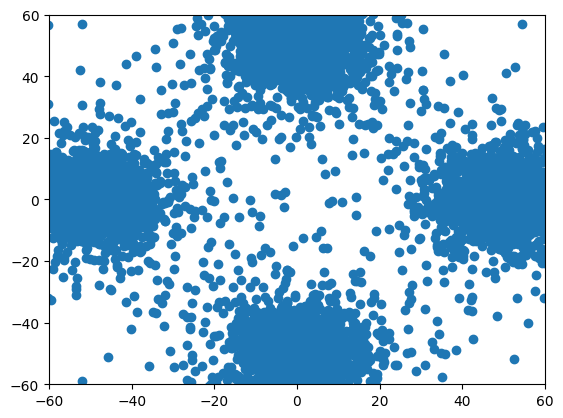

In [8]:
plt.scatter(full_data_train[:,0],full_data_train[:,1])
plt.xlim(-60,60)
plt.ylim(-60,60)
plt.show()


In [9]:
class NoiseDataset(Dataset):
    def __init__(self, length, noise_shape):
        self.length = length
        self.noise_shape = noise_shape

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return torch.randn(self.noise_shape)  # standard normal noise

In [10]:
train_dataset = TensorDataset(torch.tensor(full_data_train))
noise_shape = (full_data_train.shape[1],)  # shape of each noise sample (e.g., 100-D vector)
noise_dataset = NoiseDataset(length=len(train_dataset), noise_shape=noise_shape)
noise_loader = DataLoader(noise_dataset, batch_size=batch_size, shuffle=True)


# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

C:\Users\adity\AppData\Local\Temp\ipykernel_15744\3808938799.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(full_data_train))


In [11]:
optim1 = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-3)
optim2=torch.optim.Adam(Tail_paramNet.parameters(), lr=lr,weight_decay=1e-3)#,weight_decay=1e-3)

In [12]:

# FM_MODEL=Light_tail_FM(model,dimension,iterations,device,STEPS)
FM_MODEL=heavy_tail_FM(Tail_paramNet,model,noise2data,dimension,iterations,device,STEPS)

In [ ]:
for i in range(iterations):
    print("ITERATION-",i,"STEPS-",FM_MODEL.count)
    if FM_MODEL.steps==FM_MODEL.count:
        break
    FM_MODEL.train_epoch(optim1,optim2,train_loader,noise_loader,i)


ITERATION- 0 STEPS- 0


c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\FM_HT\scaler_grad.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


LOSS- tensor(1244.3265, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(898.9960, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(813.1556, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(879.0776, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(880.2450, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(860.9521, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(805.8397, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(742.4856, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(728.9491, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(699.6920, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(689.6368, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(685.0895, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(677.1088, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(664.1682, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(650.0222, device='cuda:0', grad_fn=<MeanBackward0>)
LOSS- tensor(618.5424, d

In [ ]:
generated_data=FM_MODEL.generate(full_data_test.shape[0])


(-70.0, 70.0)

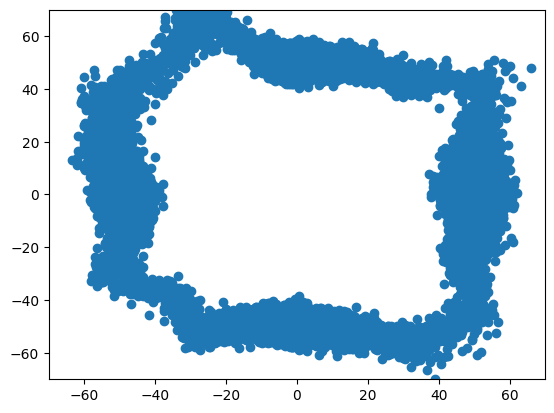

In [ ]:
plt.scatter(generated_data[:,0],generated_data[:,1])
plt.xlim(-70,70)
plt.ylim(-70,70)

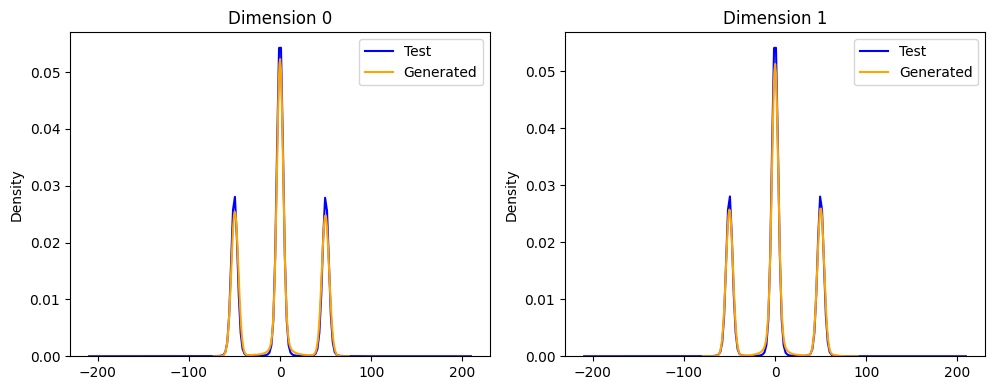

In [ ]:
plot_kde_subplots(full_data_test[0:generated_data.shape[0]],generated_data,'name',approach)

In [ ]:
compute_all_metrics(generated_data,full_data_test,dimension,num_heavy)

KURTOSIS RATIO-
-1.0153618782684062 -0.13172205151358396
tensor(6.7084)
SKEWNESS RATIO
tensor(0.9669)
loglogarea
D- 0


c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\FM_HT\C_eval.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(compute_kurtosis_ratio(torch.tensor(generated_data),torch.tensor(full_data_test)))
c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\FM_HT\C_eval.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(compute_skewness_ratio(torch.tensor(generated_data),torch.tensor(full_data_test)))
c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\FM_HT\C_eval.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  compute_loglogarea(di

KeyboardInterrupt: 